### Import libraries

In [ ]:
import numpy as np
from keras.applications import MobileNetV2
from keras.models import Model
from tensorflow import keras
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout, Dense, Input
import matplotlib.image as mpimg
import visualkeras as vk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import glob
import os

## Prepare the data

In [132]:
# Model / data parameters
img_width, img_height = 28, 28
epochs = 100
batch_size = 256
input_shape = (28, 28, 1)
num_classes = 10

In [3]:
def notMNIST_load_data() : 
    data_dir_letters = 'data/notMNIST_small'

    nb_letters = len(os.listdir(data_dir_letters))
    if nb_letters != num_classes:
        raise ValueError('The number of classes is not equal to the number of letters in the folder')

    x_train = []
    y_train = []
    x_val = []
    y_val = []
    x_test = []
    y_test = []

    # we get the number of samples in the smallest class
    min_nb_samples = float('inf')
    for letter in os.listdir(data_dir_letters):
        nb_samples = len(os.listdir(os.path.join(data_dir_letters, letter)))
        min_nb_samples = min(min_nb_samples, nb_samples)

    # 80% of the data is used for training
    # 10% for validation
    # 10% for testing
    nb_train_samples = int(min_nb_samples * 0.7)
    nb_validation_samples = int(min_nb_samples * 0.1)
    nb_test_samples = nb_samples - nb_train_samples - nb_validation_samples

    # for each letter folder, we copy the images in the train, validation or test tuple and the label
    # TODO : randomize the order of the images would be better ?
    for letter in os.listdir(data_dir_letters):
        index = 0

        for image in glob.iglob(os.path.join(data_dir_letters, letter, "*.png")):

            if index < nb_train_samples:
                pixels_array = mpimg.imread(image)
                x_train.append(pixels_array)
                y_train.append(ord(letter) - 65)
            elif index < nb_train_samples + nb_validation_samples:
                pixels_array = mpimg.imread(image)
                x_val.append(pixels_array)
                y_val.append(ord(letter) - 65)
            elif index < nb_train_samples + nb_validation_samples + nb_test_samples:
                pixels_array = mpimg.imread(image)
                x_test.append(pixels_array)
                y_test.append(ord(letter) - 65)
            index += 1
    
    return (np.array(x_train), np.array(y_train)), (np.array(x_test), np.array(y_test)), (np.array(x_val), np.array(y_val))

In [4]:
# load the data, split between train and test sets
# (x_train, y_train), (x_test, y_test) = notMNIST_load_data()
(x_train, y_train), (x_test, y_test), (x_val, y_val) = notMNIST_load_data()

In [5]:
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_val = x_val.astype("float32") / 255

In [6]:
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_val = np.expand_dims(x_val, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
print(x_val.shape[0], "validation samples")

x_train shape: (13100, 28, 28, 1)
13100 train samples
3750 test samples
1870 validation samples


In [7]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

## Build the model

In [102]:
# Transform images to 3 channels - change last dimension from 1 to 3
x_train_rgb = np.repeat(x_train, 3, -1)
x_test_rgb = np.repeat(x_test, 3, -1)
x_val_rgb = np.repeat(x_val, 3, -1)

In [133]:
# Loading MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(28, 28, 3)))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [134]:
# Compile the model
model.compile(
    loss="categorical_crossentropy", 
    optimizer="adam", 
    metrics=["accuracy"]
)

In [107]:
# Augmenting the data
datagen = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.2,
    height_shift_range=0.2, 
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)
datagen.fit(x_train_rgb)

## Train the model

In [135]:
history = model.fit(datagen.flow(x_train_rgb, y_train, batch_size=batch_size), epochs=epochs, steps_per_epoch=len(x_train_rgb) // batch_size, validation_data=(x_val_rgb, y_val))

Epoch 1/100
51/51 [==============================] - 19s 215ms/step - loss: 2.2977 - accuracy: 0.2140 - val_loss: 2.8827 - val_accuracy: 0.1000
Epoch 2/100
51/51 [==============================] - 10s 199ms/step - loss: 1.4278 - accuracy: 0.5263 - val_loss: 3.0333 - val_accuracy: 0.1000
Epoch 3/100
51/51 [==============================] - 11s 211ms/step - loss: 1.0007 - accuracy: 0.6902 - val_loss: 4.0057 - val_accuracy: 0.1000
Epoch 4/100
51/51 [==============================] - 11s 225ms/step - loss: 0.8439 - accuracy: 0.7433 - val_loss: 5.7664 - val_accuracy: 0.1000
Epoch 5/100
51/51 [==============================] - 11s 225ms/step - loss: 0.7381 - accuracy: 0.7832 - val_loss: 7.7752 - val_accuracy: 0.1000
Epoch 6/100
51/51 [==============================] - 12s 229ms/step - loss: 0.6595 - accuracy: 0.8103 - val_loss: 5.9341 - val_accuracy: 0.1000
Epoch 7/100
51/51 [==============================] - 12s 232ms/step - loss: 0.6039 - accuracy: 0.8291 - val_loss: 6.0245 - val_accuracy:

## Evaluate the trained model

In [136]:
score = model.evaluate(x_test_rgb, y_test, batch_size=batch_size)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

15/15 [==============================] - 1s 42ms/step - loss: 1.2207 - accuracy: 0.7707
Test loss: 1.2206590175628662
Test accuracy: 0.7706666588783264


### Show accuracy evoluation

In [118]:
# Plotting Train and Validation Loss
def plot_errors(history, epochs):
    epochs_range = list(range(1, epochs + 1))
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(1, figsize=(10, 6))
    plt.plot(epochs_range, train_loss, label='train_loss')
    plt.plot(epochs_range, val_loss, label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Binary Cross Entropy')
    plt.legend()
    plt.show()

In [119]:
# Plotting Train and Validation Accuracy
def plot_accurary(history, epochs):
    epochs_range = list(range(1, epochs + 1))
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    plt.figure(1, figsize=(10, 6))
    plt.plot(epochs_range, train_accuracy, label='train_accuracy')
    plt.plot(epochs_range, val_accuracy, label='val_accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Binary Cross Entropy')
    plt.legend()
    plt.show()

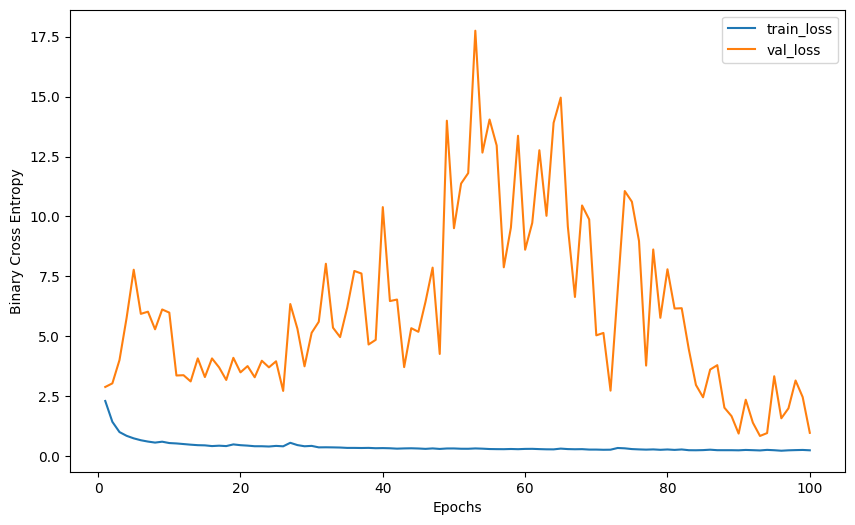

In [137]:
plot_errors(history, epochs)

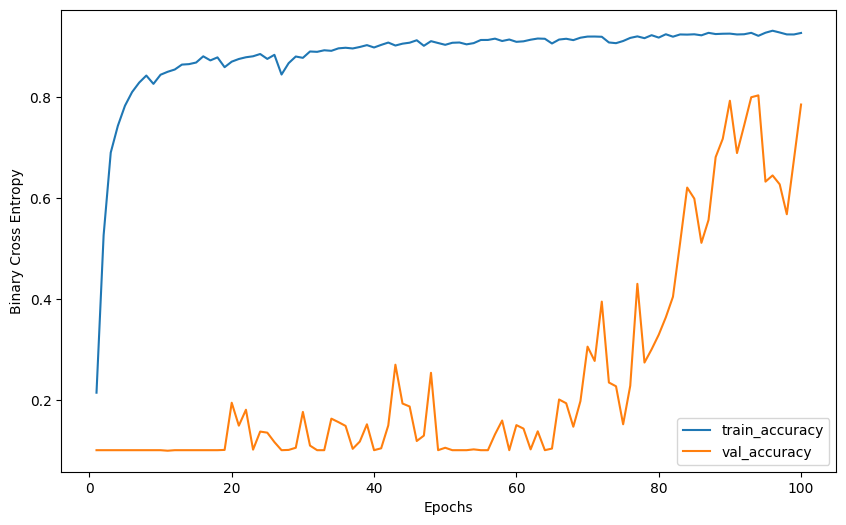

In [138]:
plot_accurary(history, epochs)

### Results

* MobileNetV2 Architecture without top layers \
100 epochs, batch size 256, steps_per_epoch=len(x_train) // batch_size \
Epoch 100/100 - loss: 0.2397 - accuracy: 0.9275 \
Test loss: 1.2206590175628662 \
Test accuracy: 0.7706666588783264 \